# INITIALIZATION AND DATA SELECTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.datasets import make_blobs
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import imageio
import time
from tqdm import tqdm_notebook
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data, label=make_blobs(n_samples=2000, n_features=2, centers=6, random_state=None)


In [0]:
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",["red","green","blue","yellow", "purple", "pink", "brown"])

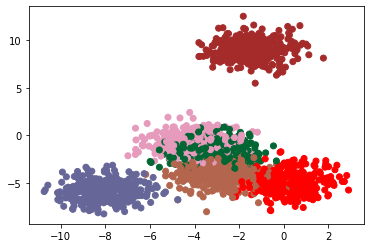

In [4]:
plt.scatter(data[:,0], data[:,1], c=label, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, stratify=label, random_state=0)

In [6]:
enc=OneHotEncoder()
Y_train_oh=enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_test_oh=enc.fit_transform(np.expand_dims(Y_test, 1)).toarray()
print(Y_train_oh.shape, Y_test_oh.shape)

(1500, 6) (500, 6)


In [0]:
W1=np.random.randn(2, 3)
W2=np.random.randn(3, 6)


#FFN CLASS _VECTORIZED WITH MOMENTUM, NAG, RMSPROP, ADAGRAD, ADAM, EVE(Hypothesized)

In [0]:
class FFN:
  def __init__(self, W1, W2):
    s=self
    s.params={}
    s.params['W1']=W1.copy()
    s.params['W2']=W2.copy()
    s.params['B1']=np.zeros((1,3))
    s.params['B2']=np.zeros((1,6))
    s.num_layers=2
    s.gradients={}
    s.update_params={}
    s.prev_update_params={}
    for i in range(s.num_layers + 1):
      s.update_params['v_w'+str(i)]=0
      s.update_params['v_b'+str(i)]=0
      s.update_params['m_w'+str(i)]=0
      s.update_params['m_b'+str(i)]=0
      s.prev_update_params['v_w'+str(i)]=0
      s.prev_update_params['v_b'+str(i)]=0
  
  def sigmoid(s, X):
    return 1/(1+np.exp(-X))

  def grad_activation(s, X):
    return X*(1-X)
  
  def softmax(s, X):
    nexp=np.exp(X)
    return nexp/np.sum(nexp, axis=1).reshape(-1, 1)
  
  def forward_pass(s, X, params=None):
    if params is None:
      params=s.params
    s.A1=np.matmul(X, params['W1']) + params['B1'] #N,2 x 2,3 + 1,3 -> N,3
    s.H1=s.sigmoid(s.A1)#N,3
    s.A2=np.matmul(s.H1, params['W2']) + params['B2']# N,3 x 3,6 + 1,6 -> N,6
    s.H2=s.softmax(s.A2)# N,6

    return s.H2

  def grad_calc(s, X, Y, params=None):
    if params is None:
      params=s.params

    s.forward_pass(X, params)
    m=X.shape[0]

    s.gradients['DA2']=s.H2-Y#N,6
    s.gradients['DW2']=np.matmul(s.H1.T, s.gradients['DA2'])#3,N x N,6-> 3,6
    s.gradients['DB2']=np.sum(s.gradients['DA2'], axis=0).reshape(1,-1)#1,6

    s.gradients['DH1']=np.matmul(s.gradients['DA2'], params['W2'].T)#N,6 x 6,3 = N,3
    s.gradients['DA1']=np.multiply(s.gradients['DH1'],s.grad_activation(s.H1))#N,3
    s.gradients['DW1']=np.matmul(X.T, s.gradients['DA1'])
    s.gradients['DB1']=np.sum(s.gradients['DA1'], axis=0).reshape(1,-1)
    
  def fit(s, X, Y, epochs=1, algo='GD', display_loss=True, eta=1, batch_size=32, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9):
    if display_loss:
      loss={}
    for epoch in tqdm_notebook(range(epochs), total=epochs,  unit="EPOCHS"):
      m=X.shape[0]
      if algo == "GD":
        s.grad_calc(X,Y)
        for i in range(1,s.num_layers+1):
          s.params["W"+str(i)]-=eta*(s.gradients['DW'+str(i)])/m
          s.params['B'+str(i)]-=eta*(s.gradients['DB'+str(i)])/m
      
      if algo=='MiniBatch':
        for k in range(0, m, batch_size):
          s.grad_calc(X[k:k+batch_size], Y[k:k+batch_size])
          for i in range(1, s.num_layers+1):
            s.params["W"+str(i)]-=eta*(s.gradients['DW'+str(i)])/batch_size
            s.params["B"+str(i)]-=eta*(s.gradients['DB'+str(i)])/batch_size

      if algo=='Momentum':
        s.grad_calc(X,Y)
        for i in range(1, s.num_layers+1):
          s.update_params['v_w'+str(i)]=gamma*s.update_params['v_w'+str(i)] + eta*s.gradients['DW'+str(i)]/m
          s.update_params['v_b'+str(i)]=gamma*s.update_params['v_b'+str(i)] + eta*s.gradients['DB'+str(i)]/m
          s.params['W'+str(i)]-=s.update_params['v_w'+str(i)]
          s.params['B'+str(i)]-=s.update_params['v_b'+str(i)]
        
      if algo=="NAG":
        temp_params={}
        for i in range(1, s.num_layers+1):
          s.update_params['v_w'+str(i)]=gamma*s.prev_update_params['v_w'+str(i)]
          s.update_params['v_b'+str(i)]=gamma*s.prev_update_params['v_b'+str(i)]
          temp_params['W'+str(i)]=s.params['W'+str(i)]-s.update_params['v_w'+str(i)]
          temp_params['B'+str(i)]=s.params['B'+str(i)]-s.update_params['v_b'+str(i)]

        s.grad_calc(X,Y,temp_params)

        for i in range(1, s.num_layers+1):
          s.update_params['v_w'+str(i)]=gamma*s.update_params['v_w'+str(i)]+eta*s.gradients['DW'+str(i)]/m
          s.update_params['v_b'+str(i)]=gamma*s.update_params['v_b'+str(i)]+eta*s.gradients['DB'+str(i)]/m
          s.params['W'+str(i)]-=eta*s.update_params['v_w'+str(i)]
          s.params['B'+str(i)]-=eta*s.update_params['v_b'+str(i)]
        s.prev_update_params=s.update_params

      if algo=='AdaGrad':
        s.grad_calc(X,Y)
        for i in range(1, s.num_layers+1):
          s.update_params['v_w'+str(i)]+= s.gradients['DW'+str(i)]**2
          s.update_params['v_b'+str(i)]+= s.gradients['DB'+str(i)]**2
          s.params['W'+str(i)]=s.params['W'+str(i)]- (eta*s.gradients['DW'+str(i)]/m)/(np.sqrt(s.update_params['v_w'+str(i)])+eps)
          s.params['B'+str(i)]=s.params['B'+str(i)]- (eta*s.gradients['DB'+str(i)]/m)/(np.sqrt(s.update_params['v_b'+str(i)])+eps)
      if algo=='RMS':
        s.grad_calc(X,Y)
        for i in range(1, s.num_layers+1):
          s.update_params['v_w'+str(i)]= beta*s.update_params['v_w'+str(i)]+(1-beta)*(s.gradients['DW'+str(i)]**2)
          s.update_params['v_b'+str(i)]= beta*s.update_params['v_b'+str(i)]+(1-beta)*(s.gradients['DB'+str(i)]**2)
          s.params['W'+str(i)]-= (eta*s.gradients['DW'+str(i)])/(np.sqrt(s.update_params['v_w'+str(i)]+eps))
          s.params['B'+str(i)]-= (eta*s.gradients['DB'+str(i)])/(np.sqrt(s.update_params['v_b'+str(i)]+eps))

      # if algo=='Adam':
      #   s.grad_calc(X,Y)
      #   nup=0
      #   for i in range(1, s.num_layers+1):
      #     s.update_params['m_w'+str(i)]=beta1*(s.update_params['m_w'+str(i)])+(1-beta1)*(s.gradients['DW'+str(i)])
      #     s.update_params['v_w'+str(i)]=beta2*(s.update_params['v_w'+str(i)])+(1-beta2)*(s.gradients['DW'+str(i)]**2)
      #     m_w=s.update_params['m_w'+str(i)]/(1-np.power(beta1, nup))
      #     v_w=s.update_params['v_w'+str(i)]/(1-np.power(beta2, nup))
      #     s.params['W'+str(i)]-= (eta*m_w)/(np.sqrt(v_w)+eps)

          
          
      #     s.update_params['m_b'+str(i)]=beta1*(s.update_params['m_b'+str(i)])+(1-beta1)*(s.gradients['DB'+str(i)])
      #     s.update_params['v_b'+str(i)]=beta2*(s.update_params['v_b'+str(i)])+(1-beta2)*(s.gradients['DB'+str(i)]**2)
      #     m_b=s.update_params['m_b'+str(i)]/(1-np.power(beta1, nup))
      #     v_b=s.update_params['v_b'+str(i)]/(1-np.power(beta2, nup))
      #     s.params['B'+str(i)]-= (eta*m_b)/(np.sqrt(v_b)+eps)


      elif algo == "Adam":
        s.grad_calc(X, Y)
        num_updates=0
        for i in range(1,s.num_layers+1):
          num_updates+=1
          s.update_params["m_w"+str(i)]=beta1*s.update_params["m_w"+str(i)]+(1-beta1)*(s.gradients["DW"+str(i)]/m)
          s.update_params["v_w"+str(i)]=beta2*s.update_params["v_w"+str(i)]+(1-beta2)*((s.gradients["DW"+str(i)]/m)**2)
          m_w_hat=s.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=s.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          s.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          s.update_params["m_b"+str(i)]=beta1*s.update_params["m_b"+str(i)]+(1-beta1)*(s.gradients["DB"+str(i)]/m)
          s.update_params["v_b"+str(i)]=beta2*s.update_params["v_b"+str(i)]+(1-beta2)*((s.gradients["DB"+str(i)]/m)**2)
          m_b_hat=s.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=s.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          s.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
           

      if display_loss:
        Y_pred=s.predict(X)
        loss[epoch]=log_loss(np.argmax(Y, axis=1), Y_pred)
    if display_loss:
      plt.plot(list(loss.values()), '-o', markersize=5)
      plt.xlabel('EPOCH')
      plt.ylabel('LOG_LOSS')
      plt.show()

  def predict(s, X):
    y_pred=s.forward_pass(X)
    return np.array(y_pred).squeeze()



In [0]:
ffn=FFN(W1, W2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


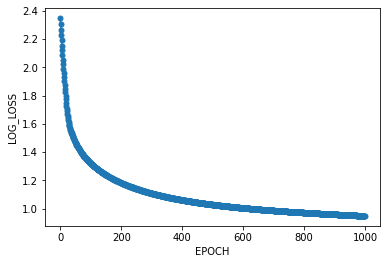

In [10]:
ffn.fit(X_train, Y_train_oh, epochs=1000, eta=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


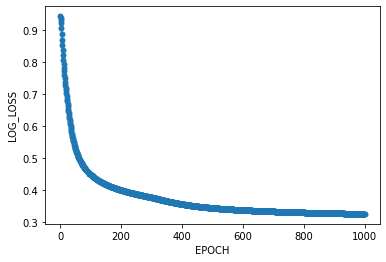

In [11]:
ffn.fit(X_train,Y_train_oh, epochs=1000, algo="MiniBatch", eta=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


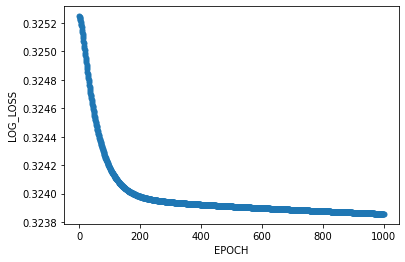

In [12]:
ffn.fit(X_train,Y_train_oh, epochs=1000, algo="Momentum", eta=0.001, gamma=0.9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


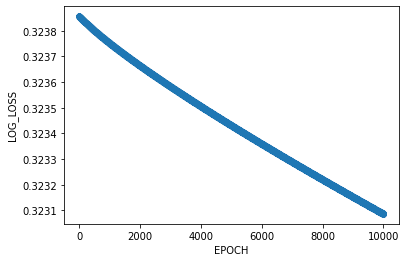

In [13]:
ffn.fit(X_train,Y_train_oh, epochs=10000, algo="NAG", eta=0.05, gamma=0.9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


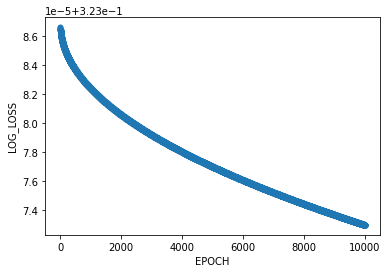

In [14]:
ffn.fit(X_train,Y_train_oh, epochs=10000, algo="AdaGrad", eta=0.01, gamma=0.9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


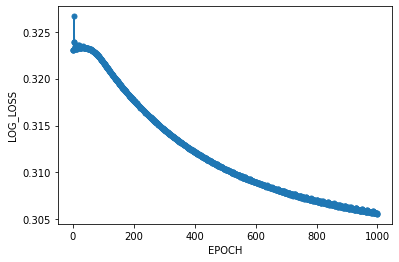

In [15]:
ffn.fit(X_train,Y_train_oh, epochs=1000, algo='RMS', eta=0.01, beta=0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


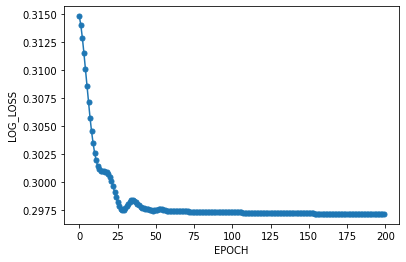

In [31]:
ffn.fit(X_train,Y_train_oh, epochs=200, algo='Adam', eta=0.001)